# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages, which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission if necessary. 

> **Note**: Once you have completed all of the code implementations, you need to finalize your work by exporting the iPython Notebook as an HTML document. Before exporting the notebook to html, all of the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission. 

In addition to implementing code, there is a writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project/blob/master/writeup_template.md) that can be used to guide the writing process. Completing the code template and writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/481/view) for this project.

The [rubric](https://review.udacity.com/#!/rubrics/481/view) contains "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. The stand out suggestions are optional. If you decide to pursue the "stand out suggestions", you can include the code in this Ipython notebook and also discuss the results in the writeup file.


>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---
## Step 0: Load The Data

In [1]:
import constants as C
from NeuralNetwork import NeuralNetwork as NN 
from preprocessing.preprocess import process as pre_processor
import pickle
from load_labels import get_sign_titles
import numpy as np
import tensorflow as tf
import time
import tensorflow.contrib.slim as slim
import PIL.Image as Image
import os
import cv2
TRAINING_MODE = True

training_file = './train.p'
validation_file = './valid.p'
testing_file = './test.p'
model_save_file = C.MODEL_PATH

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']


### Helper Files Used in the project - In the imports Above 

##### constants.py

In [ ]:
BATCH_SIZE = 128
EVAL_BATCH_SIZE = 2048
ALPHA = 5e-3
EPOCHS = 200
KEEP_PROB = 0.5
N_CLASSES = 43
DIMENSIONS = (32, 32, 3)
RESUME = True
MODEL_PATH = './model_final'
ANGLE = 15
TRANSLATION = 0.2
COUNT = 10000

##### load_labels.py

In [ ]:
import csv

def get_sign_titles():
    sign_titles = []
    with open('signnames.csv', 'rt', encoding='utf8') as f:
        sign_names = csv.reader(f, delimiter=',')
        for i, row in enumerate(sign_names):
            if i != 0:
                sign_titles.append(row[1])
    return sign_titles

##### preprocess.py

In [ ]:
import numpy as np
import constants as C

def process(X, y):
    X = X.astype('float32')
    X = (X - 128.) / 128.
    y_onehot = np.zeros((y.shape[0], C.N_CLASSES))
    for i, onehot_label in enumerate(y_onehot):
        onehot_label[y[i]] = 1.
    y = y_onehot
    return X, y

##### NeuralNetwork.py

In [ ]:
import tensorflow as tf
import tensorflow.contrib.slim as slim
import constants as C
class NeuralNetwork:

    def __init__(self, x):
        self.current_layer = None
        self.x = x

    def convolution_layer(self, output_depth, filter_width, stride, padding, scope, initial_layer=False):
        if initial_layer:
            self.current_layer = slim.conv2d(self.x, output_depth, [filter_width, filter_width], [stride,stride], scope=scope, padding=padding)
        else:
            self.current_layer = slim.conv2d(self.current_layer, output_depth, [filter_width, filter_width], stride, scope=scope, padding=padding)
        return self

    def max_pool_layer(self, filter_width, stride, padding, scope):
        self.current_layer = slim.max_pool2d(self.current_layer, [filter_width, filter_width], stride, padding=padding, scope=scope)
        return self

    def inception_layer(self, output_depth):
        with slim.arg_scope([slim.conv2d], normalizer_fn=slim.batch_norm):
            ic1_1 = slim.conv2d(self.current_layer, output_depth, [1, 1], stride=5, scope='ic1_1')

            ic2_1 = slim.conv2d(self.current_layer, output_depth, [1, 1], stride=5, scope='ic2_1')
            ic2_2 = slim.conv2d(ic2_1, output_depth, [3, 3], stride=1, scope='ic2_2')

            ic3_1 = slim.conv2d(self.current_layer, output_depth, [1, 1], stride=5, scope='ic3_1')
            ic3_2 = slim.conv2d(ic3_1, output_depth, [5, 5], stride=1, scope='ic3_2')

            ic4_1 = slim.max_pool2d(self.current_layer, [1, 1], 1, padding='SAME',scope='ic4_1')
            ic4_2 = slim.conv2d(self.current_layer, output_depth, [1, 1], scope='ic4_1')

            inception_layer = {
                'layer1': [ic1_1],
                'layer2': [ic2_1, ic2_2],
                'layer3': [ic3_1, ic3_2],
                #'layer4': [ic4_1_reshape, ic4_2_reshape]
            }
            inception_layers = []
            for group in inception_layer.values():
                for layer in group:
                    inception_layers.append(layer)
            self.current_layer = tf.concat(inception_layers, 1)
        return self

    def flatten(self):
        self.current_layer = tf.contrib.layers.flatten(self.current_layer)
        return self

    def fully_connected_layer(self, output_depth, scope):
        self.current_layer = slim.fully_connected(self.current_layer, output_depth, scope=scope)
        return self

    def dropout_layer(self):
        self.current_layer = tf.nn.dropout(self.current_layer, keep_prob=C.KEEP_PROB)
        return self

##### fake_data.py

In [ ]:
import numpy as np
import cv2
import pickle
import constants as C


def transform_image(image, angle=C.ANGLE, translation=C.TRANSLATION):
    height, width, channels = image.shape
    center = (width // 2, height // 2)
    image = cv2.warpAffine(image, cv2.getRotationMatrix2D(center, np.random.uniform(-angle, angle), 1), (width, height))
    image = cv2.warpAffine(image, np.array([[1, 0, translation * width * np.random.uniform(-1, 1)],
                                            [0, 1, translation * height * np.random.uniform(-1, 1)]]), (width, height))
    return image

def data_aug(source, destination, count=C.COUNT):
    with open(source, mode='rb') as f:
        source_data = pickle.load(f)
    source_X, source_Y = source_data['features'], source_data['labels']
    for i in range(count):
        rand_idx = np.random.randint(source_X.shape[0])
        image = transform_image(source_X[rand_idx])
        if i == 0:
            augmented_X = np.expand_dims(image, axis=0)
            augmented_Y = np.array([source_Y[rand_idx]])
        else:
            augmented_X = np.concatenate((augmented_X, np.expand_dims(image, axis=0)))
            augmented_Y = np.append(augmented_Y, source_Y[rand_idx])
    augmented_X = np.concatenate((source_X, augmented_X))
    augmented_Y = np.concatenate((source_Y, augmented_Y))

    new_data = {'features': np.concatenate((source_X, augmented_X)), 'labels': np.concatenate((source_Y, augmented_Y))}
    print(count, " Images Augmented and Added to the dataset")
    with open(destination, mode='wb') as f:
        pickle.dump(new_data, f)
    return new_data

data_aug('train.p', 'train_aug.p')


---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below. Use python, numpy and/or pandas methods to calculate the data summary rather than hard coding the results. For example, the [pandas shape method](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.shape.html) might be useful for calculating some of the summary results. 

### Provide a Basic Summary of the Data Set Using Python, Numpy and/or Pandas

In [2]:
### Replace each question mark with the appropriate value. 
### Use python, pandas or numpy methods rather than hard coding the results
import numpy as np
import tensorflow

n_train = len(train['features'])
n_test = len(test['features'])
n_valid = len(valid['features'])
image_shape = np.array(train['features'][0]).shape
n_classes = len(np.unique(train['labels']))

print("Number of training examples =", n_train)
print("Number of validation examples =", n_valid)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)


Number of training examples = 34799
Number of validation examples = 4410
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


### Include an exploratory visualization of the dataset

Visualize the German Traffic Signs Dataset using the pickled file(s). This is open ended, suggestions include: plotting traffic sign images, plotting the count of each sign, etc.

The [Matplotlib](http://matplotlib.org/) [examples](http://matplotlib.org/examples/index.html) and [gallery](http://matplotlib.org/gallery.html) pages are a great resource for doing visualizations in Python.

**NOTE:** It's recommended you start with something simple first. If you wish to do more, come back to it after you've completed the rest of the sections.

Different Classes of Images:


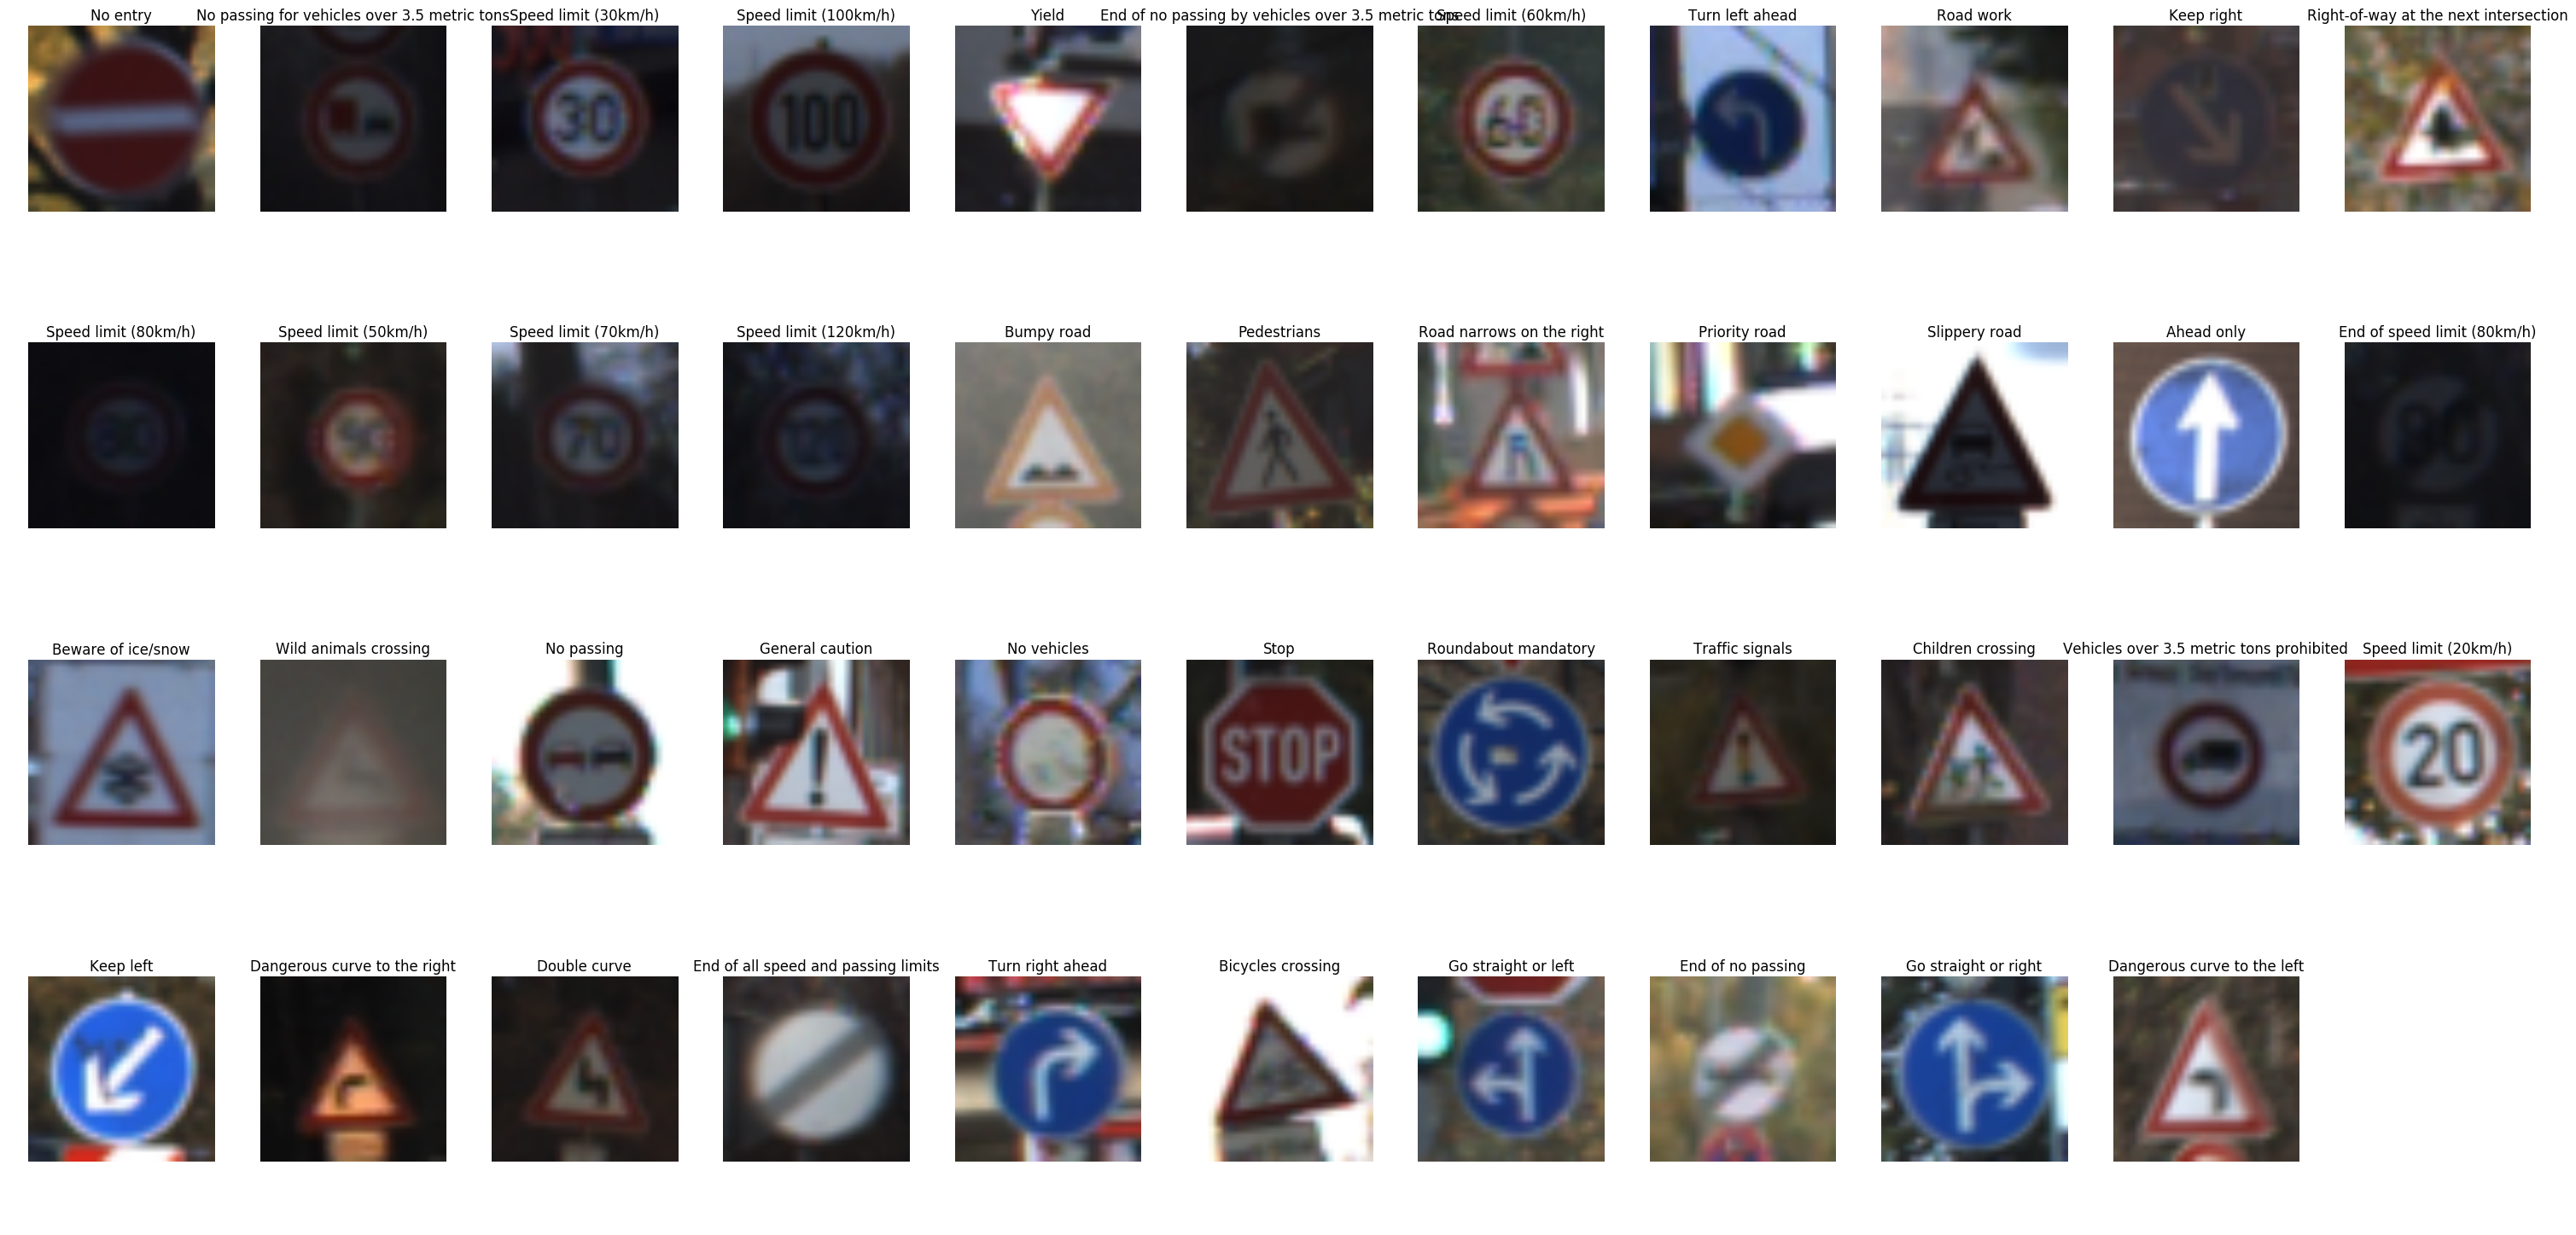

In [3]:
### Data exploration visualization code goes here.
### Feel free to use as many code cells as needed.
import random
import matplotlib.pyplot as plt
import csv
# Visualizations will be shown in the notebook.
%matplotlib inline

dict = {}
x,y,z = 4,11,0
f, axarr = plt.subplots(x,y, figsize=(30,15))
f.tight_layout()
image_list = []
image_list_index = []
for i in range(1000):
    index = random.randint(0, len(X_train))
    if y_train[index] not in dict:
        image = X_train[index].squeeze()
        image_list.append(image)
        image_list_index.append(y_train[index])
        dict[y_train[index]] = y_train[index]
print("Different Classes of Images:")

sign_titles = get_sign_titles() # from load_labels.py
count = 0
for i in range(x):
    for j in range(y):
        if z < len(image_list):
            axarr[i,j].set_axis_off()
            axarr[i,j].set_title(sign_titles[image_list_index[z]])
            axarr[i,j].imshow(image_list[z])
            z+=1
        else:
            axarr[i,j].set_axis_off()

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play! 

With the LeNet-5 solution from the lecture, you should expect a validation set accuracy of about 0.89. To meet specifications, the validation set accuracy will need to be at least 0.93. It is possible to get an even higher accuracy, but 0.93 is the minimum for a successful project submission. 

There are various aspects to consider when thinking about this problem:

- Neural network architecture (is the network over or underfitting?)
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

### Pre-process the Data Set (normalization, grayscale, etc.)

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project.

In [4]:
from sklearn.utils import shuffle
X_train, y_train = shuffle(X_train, y_train)

In [5]:
### from preprocessing.preprocess import process as pre_processor
def process(X, y):
    X = X.astype('float32')
    X = (X - 128.) / 128.
    y_onehot = np.zeros((y.shape[0], C.N_CLASSES))
    for i, onehot_label in enumerate(y_onehot):
        onehot_label[y[i]] = 1.
    y = y_onehot
    return X, y

In [6]:
### from fake_data.py
def transform_image(image, angle=C.ANGLE, translation=C.TRANSLATION):
    height, width, channels = image.shape
    center = (width // 2, height // 2)
    image = cv2.warpAffine(image, cv2.getRotationMatrix2D(center, np.random.uniform(-angle, angle), 1), (width, height))
    image = cv2.warpAffine(image, np.array([[1, 0, translation * width * np.random.uniform(-1, 1)],
                                            [0, 1, translation * height * np.random.uniform(-1, 1)]]), (width, height))
    return image

In [7]:
### from fake_data.py
def augment_data(source, destination, count=C.COUNT):
    with open(source, mode='rb') as f:
        source_data = pickle.load(f)
    source_X, source_Y = source_data['features'], source_data['labels']
    for i in range(count):
        rand_idx = np.random.randint(source_X.shape[0])
        image = transform_image(source_X[rand_idx])
        if i == 0:
            augmented_X = np.expand_dims(image, axis=0)
            augmented_Y = np.array([source_Y[rand_idx]])
        else:
            augmented_X = np.concatenate((augmented_X, np.expand_dims(image, axis=0)))
            augmented_Y = np.append(augmented_Y, source_Y[rand_idx])
    augmented_X = np.concatenate((source_X, augmented_X))
    augmented_Y = np.concatenate((source_Y, augmented_Y))

    new_data = {'features': np.concatenate((source_X, augmented_X)), 'labels': np.concatenate((source_Y, augmented_Y))}
    print(count, " Images Augmented and Added to the dataset")
    with open(destination, mode='wb') as f:
        pickle.dump(new_data, f)
    return new_data


In [8]:
with open('train_aug.p', mode='rb') as f:
    train = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']

X_train, y_train = pre_processor(X_train, y_train)
X_valid, y_valid = pre_processor(X_valid, y_valid)
X_test, y_test = pre_processor(X_test, y_test)



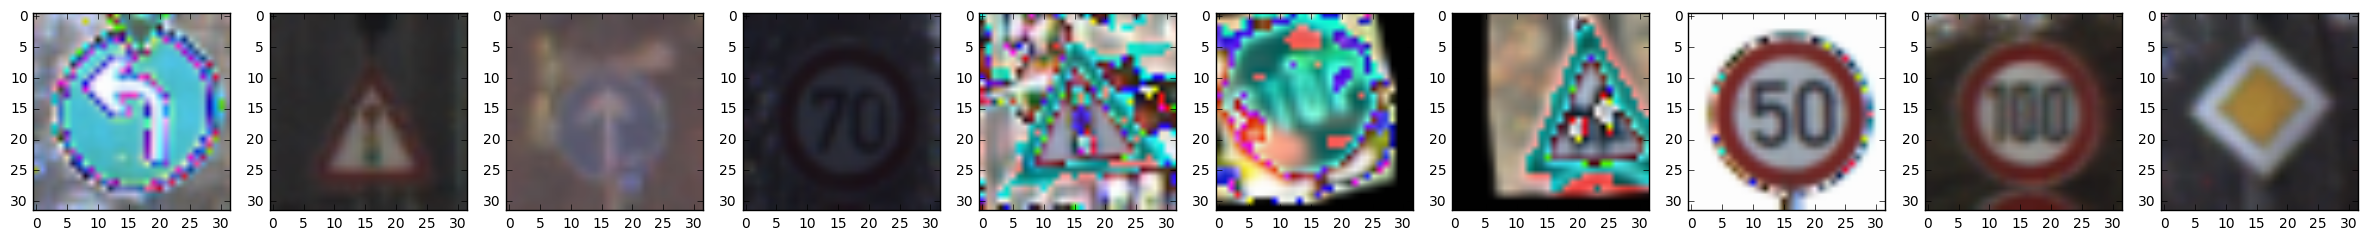

In [9]:
f, axarr = plt.subplots(1,10, figsize=(30,15))
for i in range(10):
    index = random.randint(0, len(X_train))
    image = X_train[index].squeeze()
    axarr[i].imshow(image)

### Model Architecture

In [10]:
## NN Class defined in NeuralNetwork.py
x = tf.placeholder(tf.float32, [None, 32, 32, 3])
y = tf.placeholder(tf.int32, [None, C.N_CLASSES])
keep_prob = tf.placeholder(tf.float32)

def neural_network(x):
     with slim.arg_scope([slim.conv2d], normalizer_fn=slim.batch_norm):
        logits = (NN(x)
                   .convolution_layer(output_depth=16, filter_width=3, stride=1, padding='SAME', scope='conv_1', initial_layer=True)
                   .max_pool_layer(filter_width=3, stride=1, padding='SAME', scope='conv1_maxpool')
                   .convolution_layer(output_depth=64, filter_width=5, stride=3, padding='VALID', scope='conv_2')
                   .max_pool_layer(filter_width=3, stride=1, padding='VALID', scope='conv2_maxpool')
                   .convolution_layer(output_depth=128, filter_width=3, stride=1, padding='SAME', scope='conv3')
                   .convolution_layer(output_depth=64, filter_width=3, stride=1, padding='SAME', scope='conv4')
                   .max_pool_layer(filter_width=3, stride=1, padding='VALID', scope='conv4_maxpool')
                   .flatten()
                   .fully_connected_layer(output_depth=1024, scope='fc1')
                   .dropout_layer()
                   .fully_connected_layer(output_depth=1024, scope='fc2')
                   .dropout_layer()
                   .fully_connected_layer(output_depth=C.N_CLASSES, scope='fc3'))

        return logits.current_layer

### Train, Validate and Test the Model

A validation set can be used to assess how well the model is performing. A low accuracy on the training and validation
sets imply underfitting. A high accuracy on the training set but low accuracy on the validation set implies overfitting.

In [11]:
logits = neural_network(x)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=y)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.GradientDescentOptimizer(learning_rate = C.ALPHA)
training_operation = optimizer.minimize(loss_operation)

correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, C.EVAL_BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+C.EVAL_BATCH_SIZE], y_data[offset:offset+C.EVAL_BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: C.KEEP_PROB})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

In [12]:
def train_NN(epochs=C.EPOCHS, resume=C.RESUME, save=False):
    if resume:
        saver = tf.train.Saver()
        saver.restore(sess, model_save_file)
    else:
        sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)
    print("Training...")
    print()
    total_time = time.time()
    for i in range(epochs):
        epoch_time = time.time()
        for offset in range(0, num_examples, C.BATCH_SIZE):
            end = offset + C.BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: C.KEEP_PROB})
        training_accuracy = evaluate(X_train, y_train)
        validation_accuracy = evaluate(X_valid, y_valid)
        print("EPOCH {} ...".format(i + 1))
        print("Training Accuracy = {:.3f}".format(training_accuracy),
              "Validation Accuracy = {:.3f}".format(validation_accuracy), "Epoch Time: ", time.time() - epoch_time)
        print()
    print("Time for Training: ", time.time() - total_time)
    if save:
        saver = tf.train.Saver()
        saver.save(sess, model_save_file)

    test_accuracy = evaluate(X_test, y_test)
    print("Test Accuracy = {:.3f}".format(test_accuracy))

In [13]:
def test_on_images(print_top_k = False):
    paths = ['test_images/' + file for file in os.listdir('test_images')]
    test_images = []

    for img in paths:
        image = Image.open(img)
        image = image.convert('RGB')
        image = image.resize((32, 32), Image.ANTIALIAS)
        image = np.array(list(image.getdata()))
        image = np.reshape(image, (32, 32, 3))
        test_images.append(image)

    test_images = np.array(test_images, dtype='uint8')
    sign_titles = get_sign_titles()
    test_images, _ = pre_processor(test_images, np.array([0 for _ in range(test_images.shape[0])]))

    with tf.Session() as sess:
        logits = neural_network(test_images)
        predictions = tf.argmax(logits, 1)
        saver = tf.train.Saver()
        saver.restore(sess, model_save_file)
        lgts, actual_predictions = sess.run([logits, predictions], feed_dict={x: test_images, keep_prob: 1.})
    
    if print_top_k:
        def display_top_k(image, values, indexes):
            print('Top 5 predictions for the following image (prediction: probability)')
            top_k_predictions = [sign_titles[i] for i in indexes]
            plt.imshow(image)
            plt.show()
            for i in range(5):
                print('%s: %.2f%%' % (top_k_predictions[i].replace('\n', ''), values[i] * 100))
        with tf.Session() as sess:
            logits = tf.placeholder('float', [None, C.N_CLASSES])
            k_logits, k_preds = tf.nn.top_k(tf.nn.softmax(logits), k=5)
            top_k_logits, top_k_preds = sess.run([k_logits, k_preds], feed_dict={logits: lgts})
        
            for i, test_img in enumerate(test_images):
                display_top_k(test_img, top_k_logits[i], top_k_preds[i])
    else:
        prediction_titles = [sign_titles[pred] for pred in actual_predictions]

        for i in range(test_images.shape[0]):
            print(paths[i], " --- ", prediction_titles[i])

In [13]:
# Model has been pre-trained for 200 Epochs, Resuming from therex`
with tf.Session() as sess:
    if not TRAINING_MODE:
        test_on_images()
    else:
        train_NN(10, save=False)

Training...

EPOCH 1 ...
Training Accuracy = 0.992 Validation Accuracy = 0.952 Epoch Time:  26.864166021347046

EPOCH 2 ...
Training Accuracy = 0.993 Validation Accuracy = 0.948 Epoch Time:  25.57251501083374

EPOCH 3 ...
Training Accuracy = 0.994 Validation Accuracy = 0.944 Epoch Time:  25.56815481185913

EPOCH 4 ...
Training Accuracy = 0.995 Validation Accuracy = 0.953 Epoch Time:  25.383341312408447

EPOCH 5 ...
Training Accuracy = 0.995 Validation Accuracy = 0.956 Epoch Time:  25.452939987182617

EPOCH 6 ...
Training Accuracy = 0.994 Validation Accuracy = 0.957 Epoch Time:  25.3707275390625

EPOCH 7 ...
Training Accuracy = 0.996 Validation Accuracy = 0.955 Epoch Time:  25.520773887634277

EPOCH 8 ...
Training Accuracy = 0.995 Validation Accuracy = 0.956 Epoch Time:  25.398900032043457

EPOCH 9 ...
Training Accuracy = 0.995 Validation Accuracy = 0.954 Epoch Time:  25.321115970611572

EPOCH 10 ...
Training Accuracy = 0.997 Validation Accuracy = 0.957 Epoch Time:  25.293068408966064



---

## Step 3: Test a Model on New Images

To give yourself more insight into how your model is working, download at least five pictures of German traffic signs from the web and use your model to predict the traffic sign type.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Load and Output the Images

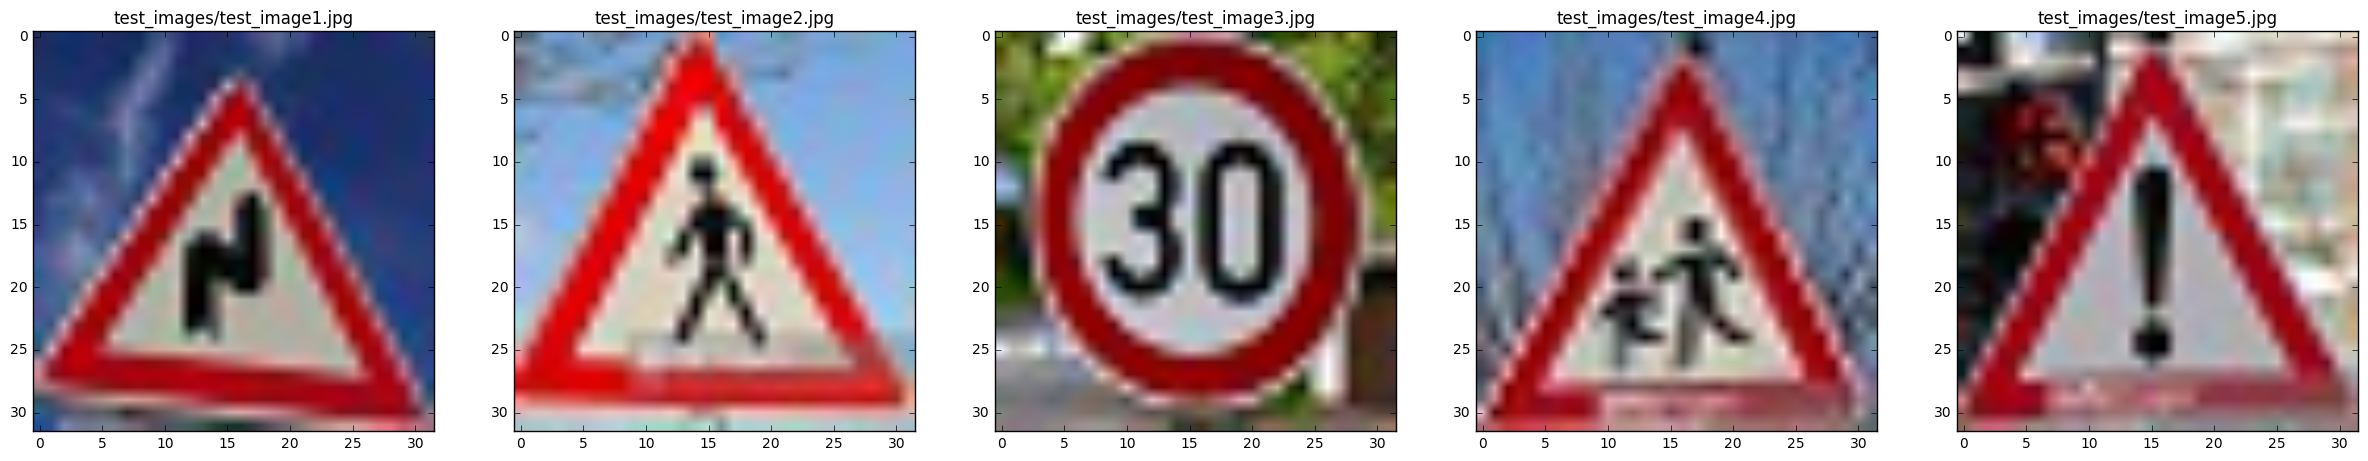

In [12]:
paths = ['test_images/' + file for file in os.listdir('test_images')]
test_images = []
for img in paths:
    image = Image.open(img)
    test_images.append(image)

f, axarr = plt.subplots(1,5, figsize=(30,15))
for i in range(5):
    axarr[i].set_title(paths[i])
    axarr[i].imshow(test_images[i])


### Predict the Sign Type for Each Image

In [13]:
TRAINING_MODE = False

with tf.Session() as sess:
    if not TRAINING_MODE:
        test_on_images()
    else:
        train_NN(10, save=False)

test_images/test_image1.jpg  ---  Right-of-way at the next intersection
test_images/test_image2.jpg  ---  Pedestrians
test_images/test_image3.jpg  ---  Speed limit (30km/h)
test_images/test_image4.jpg  ---  Children crossing
test_images/test_image5.jpg  ---  General caution


### Analyze Performance

The Network Performed Quite Well.

It predicted 4 Images correctly out of the give 5.

Accuracy of Network = 80%

### Output Top 5 Softmax Probabilities For Each Image Found on the Web

For each of the new images, print out the model's softmax probabilities to show the **certainty** of the model's predictions (limit the output to the top 5 probabilities for each image). [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. 

The example below demonstrates how tf.nn.top_k can be used to find the top k predictions for each image.

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example. The values in the array represent predictions. The array contains softmax probabilities for five candidate images with six possible classes. `tk.nn.top_k` is used to choose the three classes with the highest probability:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

Top 5 predictions for the following image (prediction: probability)


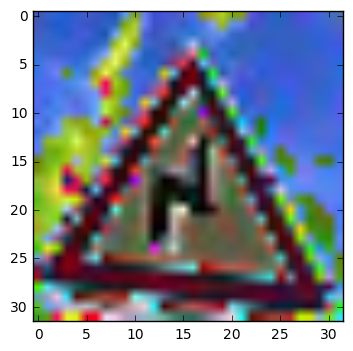

Right-of-way at the next intersection: 99.97%
Pedestrians: 0.03%
Beware of ice/snow: 0.00%
Wild animals crossing: 0.00%
Dangerous curve to the right: 0.00%
Top 5 predictions for the following image (prediction: probability)


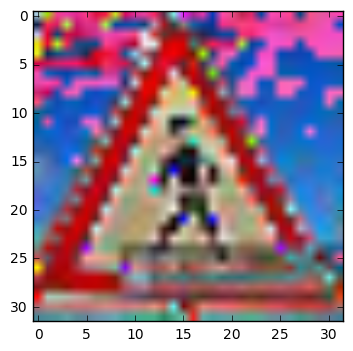

Pedestrians: 100.00%
Road narrows on the right: 0.00%
General caution: 0.00%
Right-of-way at the next intersection: 0.00%
Double curve: 0.00%
Top 5 predictions for the following image (prediction: probability)


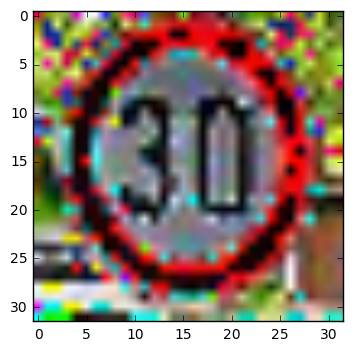

Speed limit (30km/h): 100.00%
Speed limit (50km/h): 0.00%
Speed limit (20km/h): 0.00%
Stop: 0.00%
Road narrows on the right: 0.00%
Top 5 predictions for the following image (prediction: probability)


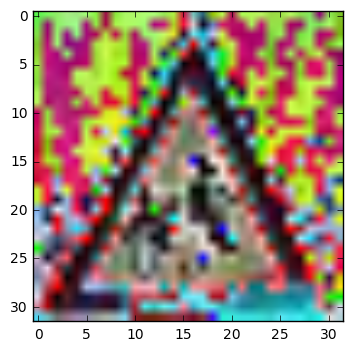

Children crossing: 99.86%
Bicycles crossing: 0.13%
Wild animals crossing: 0.01%
Beware of ice/snow: 0.01%
Road narrows on the right: 0.00%
Top 5 predictions for the following image (prediction: probability)


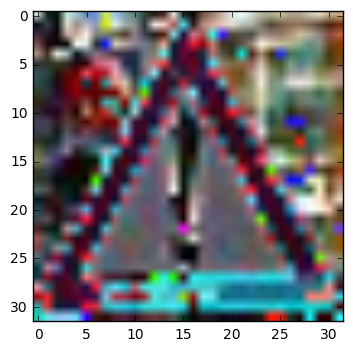

General caution: 99.98%
Pedestrians: 0.01%
Dangerous curve to the left: 0.00%
Double curve: 0.00%
Traffic signals: 0.00%


In [12]:
TRAINING_MODE = False

with tf.Session() as sess:
    if not TRAINING_MODE:
        test_on_images(print_top_k=True)
    else:
        train_NN(10, save=False)


---

## Step 4: Visualize the Neural Network's State with Test Images

 This Section is not required to complete but acts as an additional excersise for understaning the output of a neural network's weights. While neural networks can be a great learning device they are often referred to as a black box. We can understand what the weights of a neural network look like better by plotting their feature maps. After successfully training your neural network you can see what it's feature maps look like by plotting the output of the network's weight layers in response to a test stimuli image. From these plotted feature maps, it's possible to see what characteristics of an image the network finds interesting. For a sign, maybe the inner network feature maps react with high activation to the sign's boundary outline or to the contrast in the sign's painted symbol.

 Provided for you below is the function code that allows you to get the visualization output of any tensorflow weight layer you want. The inputs to the function should be a stimuli image, one used during training or a new one you provided, and then the tensorflow variable name that represents the layer's state during the training process, for instance if you wanted to see what the [LeNet lab's](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) feature maps looked like for it's second convolutional layer you could enter conv2 as the tf_activation variable.

For an example of what feature map outputs look like, check out NVIDIA's results in their paper [End-to-End Deep Learning for Self-Driving Cars](https://devblogs.nvidia.com/parallelforall/deep-learning-self-driving-cars/) in the section Visualization of internal CNN State. NVIDIA was able to show that their network's inner weights had high activations to road boundary lines by comparing feature maps from an image with a clear path to one without. Try experimenting with a similar test to show that your trained network's weights are looking for interesting features, whether it's looking at differences in feature maps from images with or without a sign, or even what feature maps look like in a trained network vs a completely untrained one on the same sign image.

<figure>
 <img src="visualize_cnn.png" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above)</p> 
 </figcaption>
</figure>
 <p></p> 


In [22]:
### Visualize your network's feature maps here.
### Feel free to use as many code cells as needed.

# image_input: the test image being fed into the network to produce the feature maps
# tf_activation: should be a tf variable name used during your training procedure that represents the calculated state of a specific weight layer
# activation_min/max: can be used to view the activation contrast in more detail, by default matplot sets min and max to the actual min and max values of the output
# plt_num: used to plot out multiple different weight feature map sets on the same block, just extend the plt number for each new feature map entry

def outputFeatureMap(image_input, tf_activation, activation_min=-1, activation_max=-1 ,plt_num=1):
    # Here make sure to preprocess your image_input in a way your network expects
    # with size, normalization, ect if needed
    # image_input =
    # Note: x should be the same name as your network's tensorflow data placeholder variable
    # If you get an error tf_activation is not defined it maybe having trouble accessing the variable from inside a function
    activation = tf_activation.eval(session=sess,feed_dict={x : image_input})
    featuremaps = activation.shape[3]
    plt.figure(plt_num, figsize=(15,15))
    for featuremap in range(featuremaps):
        plt.subplot(6,8, featuremap+1) # sets the number of feature maps to show on each row and column
        plt.title('FeatureMap ' + str(featuremap)) # displays the feature map number
        if activation_min != -1 & activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin =activation_min, vmax=activation_max, cmap="gray")
        elif activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmax=activation_max, cmap="gray")
        elif activation_min !=-1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin=activation_min, cmap="gray")
        else:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", cmap="gray")


### Question 9

Discuss how you used the visual output of your trained network's feature maps to show that it had learned to look for interesting characteristics in traffic sign images


**Answer:**

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

### Project Writeup

Once you have completed the code implementation, document your results in a project writeup using this [template](https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project/blob/master/writeup_template.md) as a guide. The writeup can be in a markdown or pdf file. 